In [31]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch
from torch import nn
import numpy as np
from scipy.signal import convolve

In [26]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [21]:
dataset = load_dataset("sh0416/ag_news")

In [22]:
class_names = ["World", "Sports", "Business", "Sci/Tech"]

In [23]:
dataset = dataset["train"].select(range(1000))
dataset = dataset.shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.3, seed=1234)
dataset["validation"] = dataset["test"]

print(dataset)


def preprocess_text(x):
    ids = tokenizer(x["description"], truncation=True, max_length=256, padding=False)[
        "input_ids"
    ]
    return {"input_ids": ids}


# Clean the dataset and tokenize it directly
dataset = dataset.map(preprocess_text)

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 700
    })
    test: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 300
    })
    validation: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 300
    })
})


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [27]:
class DataCollator:
    def __init__(self, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, batch):
        # Tokenize the texts
        labels = [example["label"] for example in batch]
        tokenized_texts = [example["input_ids"] for example in batch]
        # Pad the tokenized texts
        max_len = max(len(text) for text in tokenized_texts)
        padded_texts = [
            text + [self.tokenizer.pad_token_id] * (max_len - len(text))
            for text in tokenized_texts
        ]
        pad_mask = [
            [1] * len(text) + [0] * (max_len - len(text)) for text in tokenized_texts
        ]
        return {
            "input_ids": torch.tensor(padded_texts),
            "pad_mask": torch.tensor(pad_mask),
            "labels": torch.tensor(labels),
        }

In [30]:
def validation_step(valid_dataloader, model, criterion):
    n_valid = len(valid_dataloader.dataset)
    model.eval()
    total_loss = 0.0
    correct = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            pad_mask = batch["pad_mask"].to(DEVICE)
            output = model(input_ids, pad_mask)
            loss = criterion(output, labels)
            total_loss += loss.item()
            correct += (output.argmax(axis=-1) == labels).sum().item()
            n_iter += 1
    return total_loss / n_iter, correct / n_valid


def train_one_epoch(train_dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    n_train = len(train_dataloader.dataset)
    n_iter = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        pad_mask = batch["pad_mask"].to(DEVICE)
        class_scores = model(input_ids, pad_mask)  # (B, 4)

        loss = criterion(class_scores, labels)  # scalaire (1,)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (class_scores.argmax(axis=-1) == labels).sum().item()
        n_iter += 1

    return total_loss / n_iter, correct / n_train


def train(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    model.to(DEVICE)
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [40]:
class BaseWordEmbedClassifier(nn.Module):
    def __init__(self, vocab_size, d, n_classes=4):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d)
        self.class_projection = nn.Linear(d, n_classes)

    def seq_to_seq(self, x_embed, pad_mask):
        return x_embed

    def forward(self, input_ids, pad_mask):
        x_embed = self.embedding_layer(input_ids)  # (B, L, d)

        hidden_states = self.seq_to_seq(x_embed, pad_mask)

        n_non_pad = pad_mask.sum(
            axis=1, keepdim=True
        )  # (B, 1), 1 because of keepdim=True

        # pad_mask (B, L), x_embed (B, L, d)
        hidden_states = (
            hidden_states * pad_mask[:, :, None]
        )  # or pad_mask.unsqueeze(-1)
        x_vector = hidden_states.sum(axis=1) / n_non_pad

        class_scores = self.class_projection(x_vector)  # (B, n_classes)

        return class_scores

In [41]:
class Conv1DClassifier(BaseWordEmbedClassifier):
    def __init__(self, vocab_size, d, n_classes=4, d_conv=100, kernel_size=3):
        super().__init__(vocab_size, d, n_classes)
        self.conv1d = nn.Conv1d(d, d_conv, kernel_size, padding=kernel_size // 2)

    def seq_to_seq(self, x_embed, pad_mask=None):
        if pad_mask is None:
            pad_mask = torch.ones(x_embed.size(0), x_embed.size(1)).to(DEVICE)
        x_embed = x_embed * pad_mask[:, :, None]
        x_conv = self.conv1d(x_embed.permute(0, 2, 1)).permute(0, 2, 1)
        return x_conv

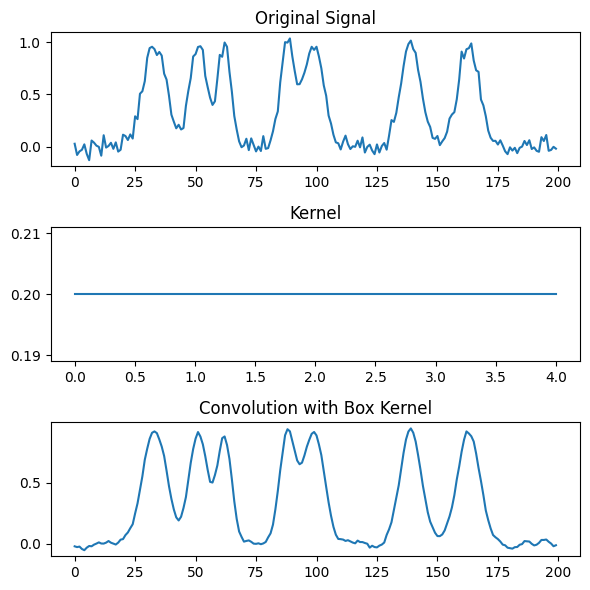

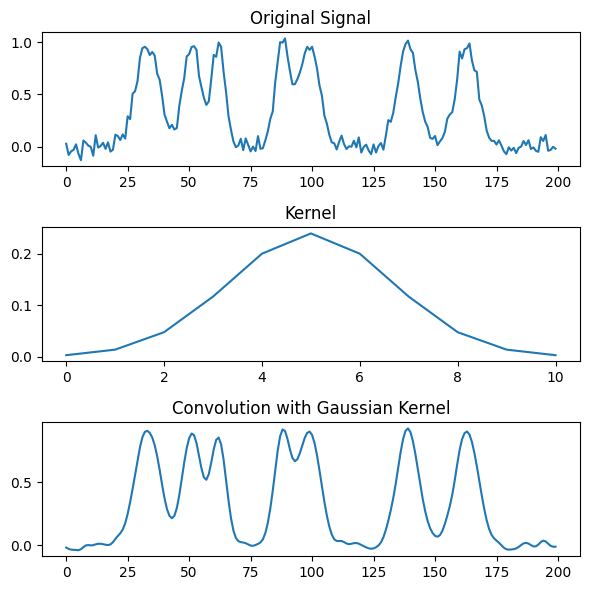

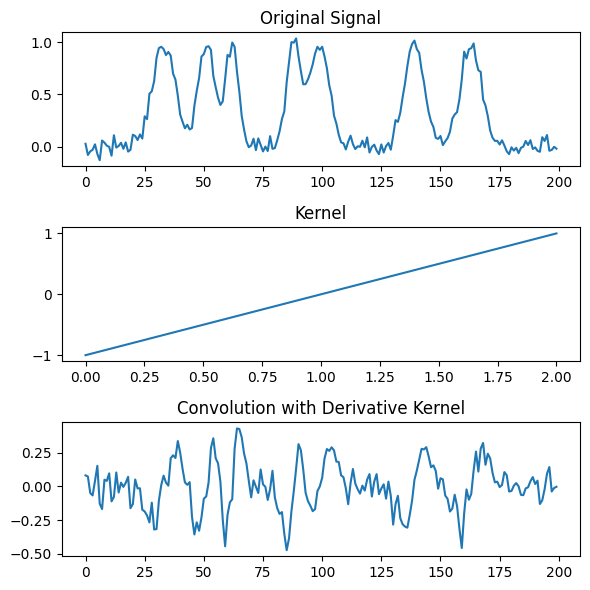

In [39]:
def generate_signal(length, num_peaks=5, peak_width=10, noise_level=0.1):
    """Generates a 1D signal with peaks and noise."""

    signal = np.random.normal(0, noise_level, length)  # Start with noise

    peak_positions = np.sort(np.random.choice(length, num_peaks, replace=False))

    for center in peak_positions:
        width = np.random.randint(peak_width // 2, peak_width)  # Varying width
        for i in range(length):
            # Gaussian peak shape
            signal[i] += np.exp(
                -((i - center) ** 2) / (2 * (width / 3) ** 2)
            )  # Adjusted width for better peaks

    return signal


def plot_convolution(signal, kernel, title="Convolution Result"):
    """Plots the original signal, the kernel, and the convolution result."""
    convolved_signal = convolve(
        signal, kernel, mode="same"
    )  # 'same' keeps output same size

    plt.figure(figsize=(6, 6))

    plt.subplot(3, 1, 1)
    plt.plot(signal)
    plt.title("Original Signal")

    plt.subplot(3, 1, 2)
    plt.plot(kernel)
    plt.title("Kernel")

    plt.subplot(3, 1, 3)
    plt.plot(convolved_signal)
    plt.title(title)

    plt.tight_layout()
    plt.show()


signal_length = 200
signal = generate_signal(
    signal_length, num_peaks=7, peak_width=15, noise_level=0.05
)  # Experiment with these parameters

box_kernel = np.ones(5) / 5  # Averaging kernel
gaussian_kernel = np.exp(-(np.linspace(-3, 3, 11) ** 2) / 2)  # Gaussian kernel
gaussian_kernel /= gaussian_kernel.sum()  # Normalize
derivative_kernel = np.array([-1, 0, 1])  # Edge detection kernel

# Perform and plot convolutions:
plot_convolution(signal, box_kernel, title="Convolution with Box Kernel")
plot_convolution(signal, gaussian_kernel, title="Convolution with Gaussian Kernel")
plot_convolution(signal, derivative_kernel, title="Convolution with Derivative Kernel")

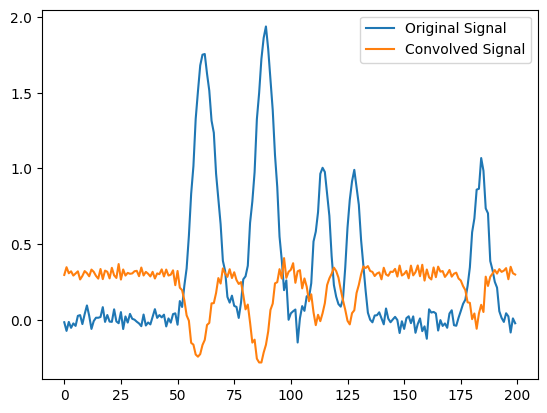

In [49]:
signal = generate_signal(signal_length, num_peaks=7, peak_width=15, noise_level=0.05)
signal = torch.tensor(signal, dtype=torch.float32).to(DEVICE)
signal = signal.unsqueeze(0).unsqueeze(-1)  # Add batch and channel dimensions
conv_model = Conv1DClassifier(
    vocab_size=signal_length, d=1, n_classes=4, d_conv=1, kernel_size=5
)
conv_output = conv_model.seq_to_seq(signal)

plt.plot(signal.cpu().numpy().squeeze(), label="Original Signal")
plt.plot(conv_output.cpu().detach().numpy().squeeze(), label="Convolved Signal")
plt.legend()

In [51]:
class RNNClassifier(BaseWordEmbedClassifier):
    def __init__(self, vocab_size, d, n_classes=4, d_rnn=100):
        super().__init__(vocab_size, d, n_classes)
        self.rnn = nn.RNN(d, d_rnn, batch_first=True)

    def seq_to_seq(self, x_embed, pad_mask=None):
        if pad_mask is None:
            pad_mask = torch.ones(x_embed.size(0), x_embed.size(1)).to(DEVICE)
        x_embed = x_embed * pad_mask[:, :, None]
        hidden_states, _ = self.rnn(x_embed)
        return hidden_states

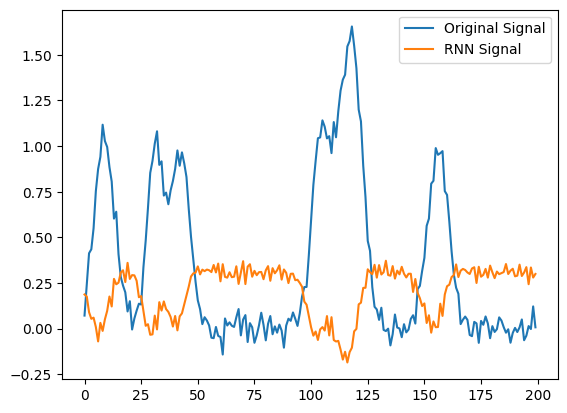

In [53]:
signal = generate_signal(signal_length, num_peaks=7, peak_width=15, noise_level=0.05)
signal = torch.tensor(signal, dtype=torch.float32).to(DEVICE)
signal = signal.unsqueeze(0).unsqueeze(-1)  # Add batch and channel dimensions
rnn_model = RNNClassifier(vocab_size=signal_length, d=1, n_classes=4, d_rnn=1)
conv_output = conv_model.seq_to_seq(signal)

plt.plot(signal.cpu().numpy().squeeze(), label="Original Signal")
plt.plot(conv_output.cpu().detach().numpy().squeeze(), label="RNN Signal")
plt.legend()